## Import Libraries

In [1]:
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch import nn

from tqdm.notebook import tqdm

## Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset

In [3]:
dataset = torchvision.datasets.StanfordCars(root=".", download=True)

In [4]:
def show_imgs(dataset, samples=12, cols=4):
    plt.figure(figsize=(10,10)) 
    for i, img in enumerate(dataset):
        if i == samples:
            break
        plt.subplot(int(samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

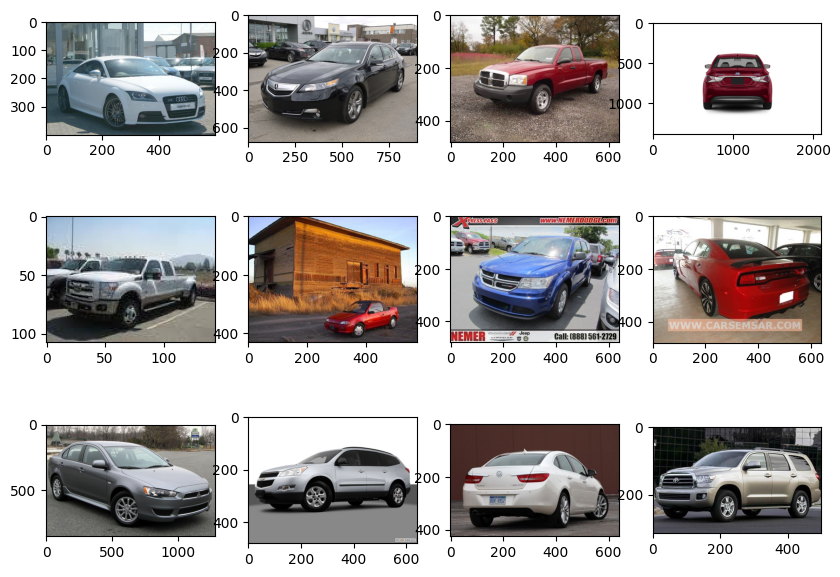

In [5]:
show_imgs(dataset)

## Dataloader

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128

def transform_dataset():
    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scale between [0, 1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ])

    train = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transforms)
    test = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transforms, split='test')
                                         
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_img(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [7]:
dataset = transform_dataset()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Forward process
#### Simulate foward diffusion

In [8]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

# Returns a specific index t of a passed list of values while considering the batch dimension
def get_index_from_list(values, t, x_shape):
    batch_size = t.shape[0]
    out = values.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# Takes an image and a timestep as input, returns the noisy version of it
def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) \
        * noise.to(device), noise.to(device)

# Beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculations for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

C:\Users\CV\AppData\Local\Temp\ipykernel_27368\3078223084.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_imgs+1, int(idx/stepsize) + 1)


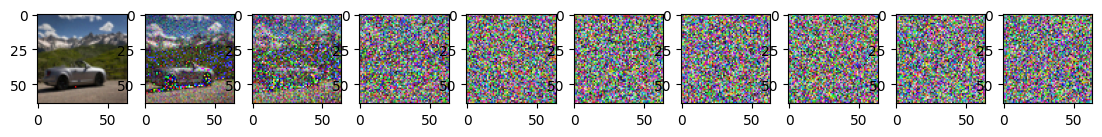

In [9]:
img = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_imgs = 10
stepsize = int(T/num_imgs)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_imgs+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(img, t)
    show_tensor_img(img)

## Backward process
### U-Net Model

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.b_norm1 = nn.BatchNorm2d(out_ch)
        self.b_norm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        h = self.b_norm1(self.relu(self.conv1(x)))   # First Convolution
        time_emb = self.relu(self.time_mlp(t))      # Time Embedding
        time_emb = time_emb[(..., ) + (None, ) * 2] # Extend last two dim
        h = h + time_emb                               # Add time channel
        h = self.b_norm2(self.relu(self.conv2(h)))   # Second Convolution
        return self.transform(h)                    # Down Or Up Sample

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Simplified variant of the Unet architecture
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Channels
        img_chs = 3
        down_chs = (64, 128, 256, 512, 1024)
        up_chs = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(img_chs, down_chs[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_chs[i], down_chs[i+1], time_emb_dim) \
            for i in range(len(down_chs)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_chs[i], up_chs[i+1], time_emb_dim, up=True) \
            for i in range(len(up_chs)-1)])

        self.output = nn.Conv2d(up_chs[-1], 3, out_dim)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep) # Embedding time
        x = self.conv0(x)           # Initial Convolution
        # U-Net
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [11]:
model = Unet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


Unet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): 

## Loss Function

In [12]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device=device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

#### Sampling

In [13]:
@torch.no_grad()
# Calls the model to predict the noise in the image and returns the denoised image. 
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_imgs = 10
    stepsize = int(T/num_imgs)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_imgs, int(i/stepsize+1))
            show_tensor_img(img.detach().cpu())
    plt.show()     

## Fit function for training

In [14]:
def fit(model, dataloader, epochs, lr):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []

    for epoch in range(epochs):
        train_loss = []
        model.train()
        bar = tqdm(dataloader)
        for step, batch in enumerate(bar):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
            loss = get_loss(model, batch[0], t)
            train_loss.append(loss.item())
            mean_tl = np.mean(train_loss)
            loss.backward()
            optimizer.step()
            bar.set_description(f"Loss {mean_tl}")

            if epoch % 5 == 0 and step == 0 and epoch != 0:
                print(f"Epoch {epoch} | step {step:03d} Loss: {mean_tl}")
                torch.save(model.state_dict(), 'weights/best_model.pth')
                print("WEIGHTS-ARE-SAVED")
                sample_plot_image()
            
        train_losses.append(mean_tl)
    return train_losses

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5 | step 000 Loss: 0.1682531237602234
WEIGHTS-ARE-SAVED


C:\Users\CV\AppData\Local\Temp\ipykernel_27368\665789743.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_imgs, int(i/stepsize+1))


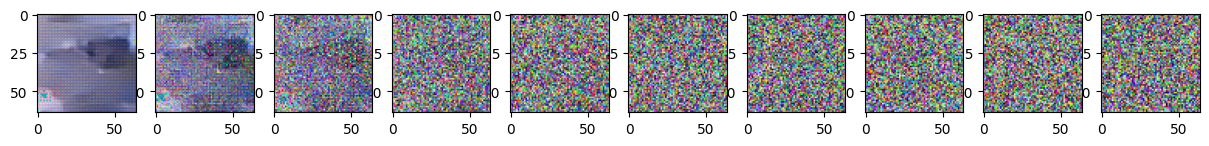

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10 | step 000 Loss: 0.1518414169549942
WEIGHTS-ARE-SAVED


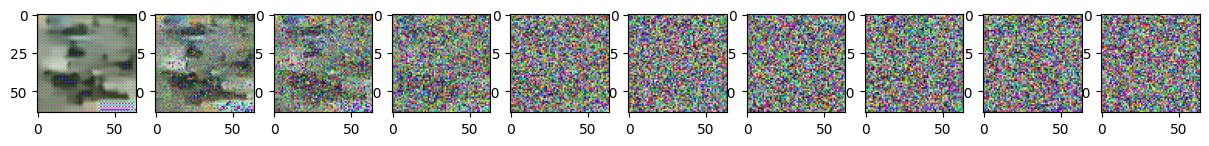

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15 | step 000 Loss: 0.1572880744934082
WEIGHTS-ARE-SAVED


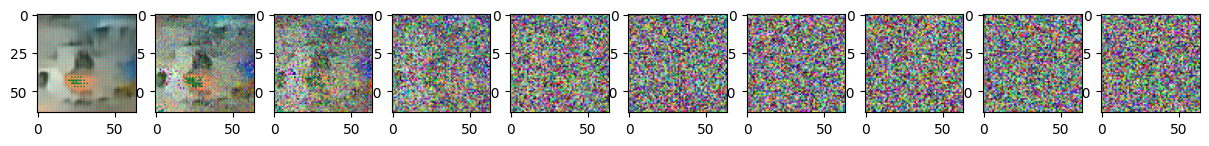

In [15]:
train_losses = fit(model=model, dataloader=dataloader, epochs=16, lr=0.001)

## Plotting Loss

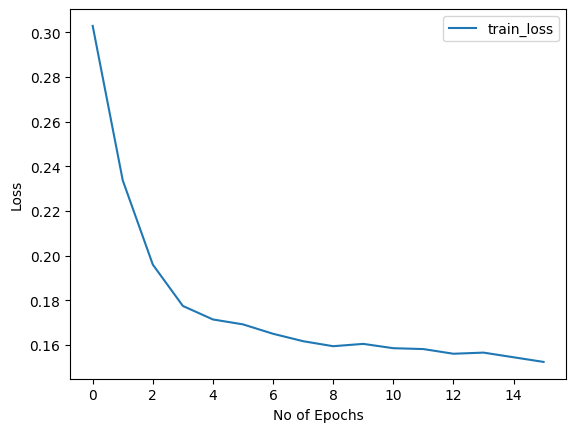

In [16]:
plt.plot(train_losses , label = 'train_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()